In [98]:
#apertura del dataset
import pandas as pd

df = pd.read_csv('../datasets/Grocery_Inventory new v1.csv')
df.head(5)

,Product_Name,Category,Supplier_Name,Warehouse_Location,Status,Product_ID,Supplier_ID,Date_Received,Last_Order_Date,Expiration_Date,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Sales_Volume,Inventory_Turnover_Rate,percentage
0,Bell Pepper,Fruits & Vegetables,Eimbee,20 Pennsylvania Parkway,Discontinued,29-017-6255,43-348-2450,3/1/2024,1/6/2025,1/31/2025,46,64,17,$4.60,96,55,1.96%
1,Vegetable Oil,Oils & Fats,Digitube,03643 Oakridge Lane,Backordered,79-569-8856,04-854-7165,4/1/2024,5/19/2024,6/11/2024,51,87,86,$2.00,24,83,0.91%
2,Parmesan Cheese,Dairy,BlogXS,73 Graedel Street,Discontinued,28-146-2641,82-995-0739,4/1/2024,12/21/2024,4/8/2024,38,67,66,$12.00,35,24,1.36%
3,Carrot,Fruits & Vegetables,Avaveo,44801 Myrtle Center,Discontinued,11-581-9869,22-867-3079,5/1/2024,12/12/2024,9/26/2024,51,60,98,$1.50,44,95,1.36%
4,Garlic,Fruits & Vegetables,Katz,6195 Monterey Center,Discontinued,13-202-4809,24-281-7685,5/1/2024,7/28/2024,5/20/2024,27,22,89,$7.00,91,77,2.17%


In [ ]:
df_products = df[['Product_Name', 'Category', 'Date_Received', 'Expiration_Date']]
df_products = df_products.rename(columns={'Product_Name': 'productos',
                    'Category': 'categoria',
                    'Date_Received':'fecha_recibido',
                    'Expiration_Date': 'fecha_expiracion'})

#Modificacion de la columna fecha de recibido a tipo de dato fecha
df_products['fecha_recibido'] = pd.to_datetime( df_products['fecha_recibido'] , format='%m/%d/%Y')

#Modificacion de la columna fecha de vencimiento a tipo de dato fecha
df_products['fecha_expiracion'] = pd.to_datetime( df_products['fecha_expiracion'] , format='%m/%d/%Y')

#Ahora se calcula el tiempo en dias de vida uitl del producto (Desde que se recibio)
df_products['vida_util_restante(dias)'] = (df_products['fecha_expiracion'] - df_products['fecha_recibido']).dt.days

#El dataset contiene productos que ya han caducado y para el modelo de ML no es util, pues no define su naturelaza de ser perecedero o no perecedero
#Por lo que los productos caducados se eliminaran del dataset
df_products = df_products[df_products['vida_util_restante(dias)'] > 0]

# Encontrar el índice de la fila con la vida útil mínima para cada producto
indices_min = df_products.groupby('productos')['vida_util_restante(dias)'].idxmin()

# Filtrar el DataFrame usando esos índices
df_products= df_products.loc[indices_min].reset_index(drop=True)


df_products

,productos,categoria,fecha_recibido,fecha_expiracion,vida_util_restante(dias)
0,Almond Flour,Grains & Pulses,2024-05-08,2024-05-13,5
1,Anchovies,Seafood,2024-06-27,2024-07-26,29
2,Apple,Fruits & Vegetables,2024-03-24,2024-04-14,21
3,Apricot,Fruits & Vegetables,2024-05-16,2024-06-06,21
4,Arabica Coffee,Beverages,2024-03-15,2024-03-30,15
...,...,...,...,...,...
114,Whole Wheat Bread,Bakery,2024-08-02,2024-12-27,147
115,Whole Wheat Flour,Grains & Pulses,2024-04-03,2024-09-06,156
116,Wild Rice,Grains & Pulses,2024-08-03,2024-09-28,56
117,Yogurt,Dairy,2024-06-01,2024-10-25,146


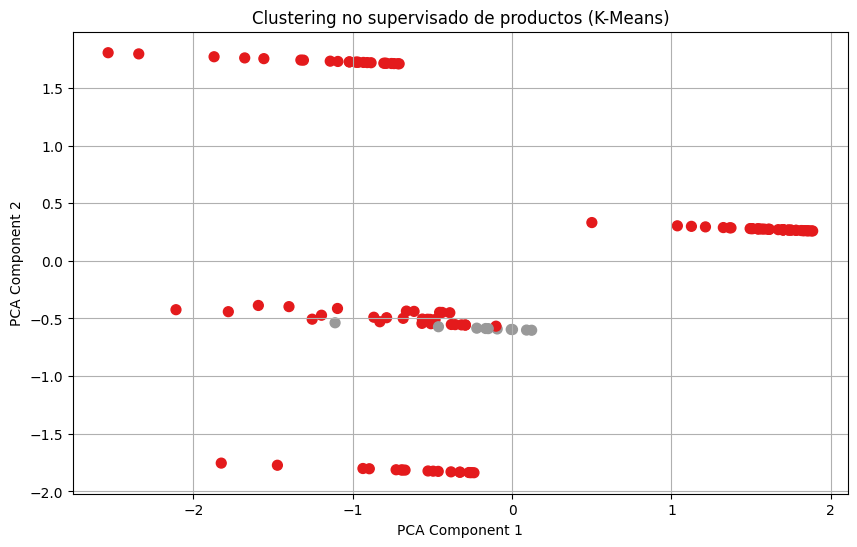

In [174]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Supongamos que df_products ya tiene:
# 'productos', 'categoria', 'vida_util_restante(dias)'

# --- 1. One-hot encoding de categoría ---
df_encoded = pd.get_dummies(df_products['categoria'])

# Añadir la vida útil restante como feature numérico
df_encoded['vida_util_restante'] = df_products['vida_util_restante(dias)']

# --- 2. Escalar los features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# --- 3. Aplicar K-Means con 2 clusters ---
kmeans = KMeans(n_clusters=2, random_state=42)
df_products['cluster'] = kmeans.fit_predict(X_scaled)

# --- 4. Reducir a 2D para graficar ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- 5. Graficar los clusters ---
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_products['cluster'], cmap='Set1', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering no supervisado de productos (K-Means)')
plt.grid(True)
plt.show()


In [172]:
promedio_cluster_1 = df_products[df_products['cluster'] == 1]['vida_util_restante(dias)'].mean()
promedio_cluster_0 = df_products[df_products['cluster'] == 0]['vida_util_restante(dias)'].mean()

print(promedio_cluster_0)
print(promedio_cluster_1)

47.55789473684211
57.416666666666664
